# Identification de la paraphrase

## Problématique 
Il s'agit de dire si deux phrases partagent le même sens, ou autrement dit si elles sont paraphrases l'une de l'autre.


##### Installation de l'environnement

In [1]:
# Installation de l'env
import os
print(os.getcwd())
os.chdir(os.path.dirname(os.getcwd()))
# Installation des packages nécessaires à ce projet
!pip install -r requirements.txt

/Users/luciegabagnou/Documents/MOSEF/ML_AVANCE/PROJET/paraphrase-identification/notebooks
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [2]:
from scripts.data_utils import HuggingFaceExtracting,ETLPipeline,WordEmbedding
from scripts.model import SiameseNet

/Users/luciegabagnou/miniconda/envs/dl_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/luciegabagnou/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/luciegabagnou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### Importation des données

Ici, pour collecter les données des données nous avons créée une classe **HuggingFaceExtracting** : une classe pour extraire des données à partir de datasets Hugging Face. Elle comprend des méthodes pour extraire les features et les labels, charger des données de datasets Hugging Face, et exporter des données dans un fichier CSV (ou laisser en DataFrame pandas).
Pour rendre uniforme les inputs dans la pipeline de preprocessing, nous avons crée une colonne "inputs" composée des paires de phrases sous forme de liste, et une "labels" ayant les labels bien encodés.


A l'origine:
On a effectué une analyse sur l'ensemble du jeu de données visible sur [HuggingFace](https://huggingface.co/datasets/bigscience/P3/viewer/glue_qqp_same_thing/). Les colonnes qui vous nous intéressez sont "inputs_pretokenized" et "targets_pretokenized":
- "inputs_pretokenized":'Are the questions "How is the life of a math student? Could you describe your own experiences?" and "Which level of prepration is enough for the exam jlpt5?" asking the same thing? '
=> Il s'agit pour chaque observation d'une paire de phrases jointes par "and" 
=> Remarque: il s'agit de questions pour l'ensemble des observations
- "targets_pretokenized": est-ce que la paire de phrases précédente est une paraphrase ou non? "yes" => Il s'agit bien d'une paraphrase et "no" les phrases ne sont pas des paraphrases


A la fin, on a:

- "inputs": ["How is the life of a math student? Could you describe your own experiences?","Which level of prepration is enough for the exam jlpt5?"] obtenu en utilisant une regex adapté au contexte
- "labels": On a encodé les labels en {0,1}: 0 => pas de paraphrase , 1 => paraphrase




In [3]:
huggingface_extractor = HuggingFaceExtracting("bigscience/P3","glue_qqp_same_thing")
huggingface_extractor.load_huggingface_dataset()

Found cached dataset p3 (/Users/luciegabagnou/.cache/huggingface/datasets/bigscience___p3/glue_qqp_same_thing/0.1.0/204f22caf7f0cbaf01a8631ec396c1cab69f8d71f276fb8619fae696536874ab)
100%|██████████| 3/3 [00:00<00:00, 203.58it/s]


In [4]:
train = huggingface_extractor.extract("train")
test = huggingface_extractor.extract("test")
validation = huggingface_extractor.extract("validation")

In [5]:
train.head()

,inputs,labels
0,[How is the life of a math student? Could you ...,0
1,"[How do I control my horny emotions?, How do y...",1
2,"[What causes stool color to change to yellow?,...",0
3,"[What can one do after MBBS?, What do i do aft...",1
4,[Where can I find a power outlet for my laptop...,0


### EDA 
Il y a 363846 observations (paires de phrases + targets) dans l'échantillon de train, 390965 dans l'échantillon de test, et 40430 dans l'échantillon de validation. Au total, on compte donc 795241 observations.

Dans un premier temps, on a réalisé une analyse exploratoire du jeu de données (dans sa globalité) pour comprendre quel était le type de données auquel nous étions confronté. 



In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def flatten(l):
    return [item for sublist in l for item in sublist]

In [7]:
data = pd.concat([train,test,validation],axis=0).reset_index()
sentences = data["inputs"].values.tolist()
sentences=flatten(sentences)

Nombre de mots median dans la phrase 10


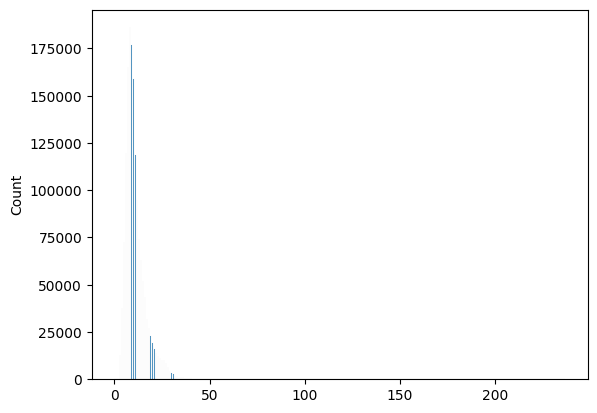

In [8]:
lenght=pd.Series(sentences).apply(lambda x: len(x.split()))
sns.histplot(lenght)
print("Nombre de mots median dans la phrase",round(lenght.median()))

In [9]:
lenght.describe()

count    1.590482e+06
mean     1.112469e+01
std      5.822297e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      2.370000e+02
dtype: float64

### Synthèse de l'analyse exploratoire
- Syntaxe : Puisque toutes les observations sont des questions, leur syntaxe devrait être plutôt similaire. Ainsi, la syntaxe n'est pas un facteur qu'il faut inclure dans notre analyse en tant que caractéristique. Cependant, si nous observions une variété de structures, cela pourrait créer de l'hétérogénéité dans les observations. Dans ce cas, nous devrions réaligner toutes les phrases pour qu'elles aient une structure similaire afin de les comparer. Par conséquent, nous pouvons simplifier notre analyse en nous concentrant sur le contenu sémantique des questions plutôt que sur leur structure syntaxique, qui est relativement simple dans ce cas. 
- Les mots: La longueur des phrases est plutôt homogène et est concentré autour de 10 mots et 75% des phrases ont une longueur inférieure à 13 mots. En ce qui concerne le lexique, nous ne devrons pas nous focaliser dessus pour discriminer les observations les unes des autres (contrairement à la classification de documents qui se concentre sur le vocabulaire). 
- Langue: Le modèle sera propre à l'anglais vu qu'il s'agit de l'unique langue employé dans les phrases.

## Preprocessing
Pour cette partie, nous avons créé une classe **ETLPipeline** : une classe représentant un pipeline ETL pour les datasets de texte. Elle comprend des méthodes pour normaliser les entrées, transformer les paires de phrases et les étiquettes en entrées appropriées pour un modèle de classification de texte, et exporter des données.
La fonction principale qui traite le processing du texte est:


```python
def standardize_text_inputs(self, input_data):
    self.lemmatizer = WordNetLemmatizer()
    
    def process_sentence(sentence):
        sentence = contractions.fix(sentence)
        sentence = sentence.replace('"', "").replace('?', "")
        tokens = nltk.word_tokenize(sentence.lower())
        if self.lemmatize_option is True:
            return [self.lemmatizer.lemmatize(word) for word in tokens if word.isalpha()]
        else:
            return [word for word in tokens if word.isalpha()]

    all_tokens = [process_sentence(sentence) for sentence in input_data]

    if self.join_option:
        all_tokens = [" ".join(tokens) for tokens in all_tokens]
        
    return all_tokens
        
```
Comme on peut le voir, elle effectue différents étapes: 
- enlève les contractions du type "I'm" et les convertit en "I am"
- remplace les signes de ponctuations parasites tel que """" et "?"
- met en minuscules les caractères et découpe en tokens les mots (selon nltk)
- si souhaité, la fonction lemmatise ce qui peut permettre d'uniformiser les mots en cas de pluriel, conjugaison..
- enfin on garde uniquement les élements sont des lettres
- selon le word embedding utilisé, on laisse le choix à l'utilisateur de s'il souhaite récupérer la phrase préprocessé sous forme de liste de tokens ou bien d'une phrase.

In [10]:
preprocessor = ETLPipeline()
#La "méthode" exécute l'ensemble de la pipeline
train_data = preprocessor.transform(train)
test_data = preprocessor.transform(test)

## Word Embedding
Dans cette partie, nous avons utilisé la classe **WordEmbedding**: elle est utilisée pour créer une représentation vectorielle pour les mots en utilisant un modèle d'embedding de mots pré-entraîné. La classe possède des méthodes:
-  pour fit un tokenizer sur les données d'entraînement (ensemble des phrases)
- pour tokenizer et padder (vectoriser et uniformiser la longueur) des séquences d'entrée (sur les phrases 1 puis 2 respectivement)
- pour charger le modèle pré-entraîné (qui devront être accessibles dans models)
- pour construire une matrice de poids qui sera utilisée pour initialiser les poids de la couche d'embedding dans un modèle de réseau de neurones: il s'agit d'une couche partagée entre les deux inputs (les deux phrases d'entrée) et les mêmes poids sont utilisés pour vectoriser toutes les phrases (même si c'est sur 2 branches différentes).

Ici, nous faisons un zoom sur la construction de la matrice des poids:

```` python
def build_weight_matrix(self):
    vocab_size = len(self.tokenizer.word_index) + 1
    weight_matrix = np.zeros((vocab_size, self.embedding_size))
    for word, i in self.tokenizer.word_index.items():
        try:
            embedding_vector = self.pretrained_model[word]
            weight_matrix[i] = embedding_vector
        except KeyError:
            weight_matrix[i] = np.random.uniform(-5, 5, self.embedding_size)
    return weight_matrix
````
Comme on peut le voir, la fonction construit une matrice de poids à partir d'un modèle d'embedding de mots pré-entraîné et d'un tokenizer. La matrice de poids est utilisée pour initialiser les poids de la couche d'embedding dans un modèle de réseau de neurones.
Plus précisément, pour chaque mot dans le vocabulaire, la méthode tente de récupérer son vecteur d'embedding à partir du modèle d'embedding pré-entraîné. Si le mot est présent dans le modèle, la méthode utilise son vecteur d'embedding comme poids pour la ligne correspondante dans la matrice de poids. Si le mot n'est pas présent dans le modèle, la méthode initialise une ligne aléatoire de la matrice de poids avec des valeurs uniformément distribuées entre -5 et 5.




Ici, on a utilisé un modèle FastText (explication dans le rapport) car il semblait le plus adapté pour traiter les mots "hors vocabulaire" c'est-à-dire les mots non connus lors de la prédiction (si typiquement un mot d'une prédiction n'était pas présent dans l'échantillon d'apprentissage). 
Nous tenterons plus tard de changer de modèle en utilisant Word2Vec pour voir si cela peut améliorer les performances.


Ici, on effectue différentes étapes:
- On instancie l'objet qui fait le word-embedding en indiquant le type de modèle pré-entraîné et le chemin d'accès du modèle utilisé
- On ajuste le tokenizer propre au modèle à partir du corpus de texte d'entraînement (il s'agit d'une vectorisation simple)
- On charge le modèle pré-entrainé 
- On récupère les inputs tokenizés et uniformisés en longueur
- On créée une matrice de poids basé sur la fonction vu précédemment


In [11]:

word_embedder = WordEmbedding(15,"FastText","cc.en.100.bin")
word_embedder.tokenizer(train_data["sentences_1"]+ train_data["sentences_2"])
word_embedder.load_pretrained_model()
train_sentences_1 = word_embedder.tokenize_and_pad(train_data["sentences_1"])
train_sentences_2 = word_embedder.tokenize_and_pad(train_data["sentences_2"])

In [12]:
weight_matrix = word_embedder.build_weight_matrix()

In [13]:
#On fait la même chose pour l'échantillon de test
test_data = preprocessor.transform(test)
test_sentences_1 = word_embedder.tokenize_and_pad(test_data["sentences_1"])
test_sentences_2 = word_embedder.tokenize_and_pad(test_data["sentences_2"])

In [14]:
"""
Trial 5 Complete [01h 07m 47s]
val_accuracy: 0.9359405636787415
Pour LSTM simple
Best val_accuracy So Far: 0.9359405636787415
Total elapsed time: 05h 43m 29s
INFO:tensorflow:Oracle triggered exit
"""

import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import keras.backend as K

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = tf.cast(y_true, tf.float32) # convertir y_true en float32
    return tf.keras.backend.mean(y_true * tf.keras.backend.square(y_pred) + (1 - y_true) * tf.keras.backend.square(tf.keras.backend.maximum(margin - y_pred, 0)))
def binary_crossentropy(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)
def manhattan_distance(A, B):
    return tf.keras.backend.sum(tf.keras.backend.abs(A - B), axis=1, keepdims=True)

def build_model(hp):
    input_dim = 15
    input_dim_embedding = weight_matrix.shape[0]
    output_dim_embedding = weight_matrix.shape[1]
    distance_layer_function = manhattan_distance

    input1 = tf.keras.layers.Input(shape=(input_dim,))
    input2 = tf.keras.layers.Input(shape=(input_dim,))

    shared_embedding = tf.keras.layers.Embedding(input_dim=input_dim_embedding, output_dim=output_dim_embedding, weights=[weight_matrix])
    shared_lstm = tf.keras.layers.LSTM(hp.Int('lstm_layers', min_value=32, max_value=256, step=32))
    encoded1 = shared_lstm(shared_embedding(input1))
    encoded1 = tf.keras.layers.BatchNormalization()(encoded1)
    encoded2 = shared_lstm(shared_embedding(input2))
    encoded2 = tf.keras.layers.BatchNormalization()(encoded2)
    merged_vector = tf.keras.layers.Lambda(lambda x: distance_layer_function(x[0], x[1]))([encoded1, encoded2])
    output = tf.keras.layers.BatchNormalization()(merged_vector)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
    siamese_net = tf.keras.models.Model(inputs=[input1, input2], outputs=output)

    optimizer = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5]))
    siamese_net.compile(loss=contrastive_loss, optimizer=optimizer, metrics=['accuracy'])

    return siamese_net

# Split data into training and validation sets

# Create a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='my_dir',
    project_name='my_project')
# Define a callback to stop training if validation accuracy stops improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Search for the best hyperparameters
tuner.search(
    [train_sentences_1,train_sentences_2],
    np.array(train_data["label"]),
    epochs=5,
    validation_data=([test_sentences_1,test_sentences_2], np.array(test_data["label"])),
    callbacks=[stop_early]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]


# Evaluate the model on the test set


INFO:tensorflow:Reloading Oracle from existing project my_dir/my_project/oracle.json
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-27 07:43:24.571300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-27 07:43:24.571401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


INFO:tensorflow:Reloading Tuner from my_dir/my_project/tuner0.json

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
96                |256               |lstm_layers
rmsprop           |rmsprop           |optimizer
1e-05             |0.001             |learning_rate

Epoch 1/5


2023-03-27 07:43:25.757600: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-27 07:43:26.948914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:43:27.262295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:43:27.262769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:43:27.692539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:43:27.713331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   19/11371 [..............................] - ETA: 9:02 - loss: 0.3013 - accuracy: 0.5641

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import keras.backend as K

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = tf.cast(y_true, tf.float32) # convertir y_true en float32
    return tf.keras.backend.mean(y_true * tf.keras.backend.square(y_pred) + (1 - y_true) * tf.keras.backend.square(tf.keras.backend.maximum(margin - y_pred, 0)))
def binary_crossentropy(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)
def manhattan_distance(A, B):
    return tf.keras.backend.sum(tf.keras.backend.abs(A - B), axis=1, keepdims=True)

def build_model(hp):
    input_dim = 15
    input_dim_embedding = weight_matrix.shape[0]
    output_dim_embedding = weight_matrix.shape[1]
    distance_layer_function = manhattan_distance

    input1 = tf.keras.layers.Input(shape=(input_dim,))
    input2 = tf.keras.layers.Input(shape=(input_dim,))

    shared_embedding = tf.keras.layers.Embedding(input_dim=input_dim_embedding, output_dim=output_dim_embedding, weights=[weight_matrix])
    shared_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(hp.Int('lstm_layers', min_value=32, max_value=256, step=32)))
    encoded1 = shared_lstm(shared_embedding(input1))
    encoded1 = tf.keras.layers.BatchNormalization()(encoded1)
    encoded2 = shared_lstm(shared_embedding(input2))
    encoded2 = tf.keras.layers.BatchNormalization()(encoded2)
    merged_vector = tf.keras.layers.Lambda(lambda x: distance_layer_function(x[0], x[1]))([encoded1, encoded2])
    output = tf.keras.layers.BatchNormalization()(merged_vector)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(output)
    siamese_net = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
        # Choix de l'optimiseur et du learning rate
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    siamese_net.compile(loss=contrastive_loss, optimizer=optimizer, metrics=['accuracy'])

    return siamese_net

# Split data into training and validation sets

# Create a tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=2,
    directory='my_dir',
    project_name='my_project')
# Define a callback to stop training if validation accuracy stops improving
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Search for the best hyperparameters
tuner.search(
    [train_sentences_1,train_sentences_2],
    np.array(train_data["label"]),
    epochs=5,
    validation_data=([test_sentences_1,test_sentences_2], np.array(test_data["label"])),
    callbacks=[stop_early]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=10)[0]


In [ ]:
best_learning_rate = best_hps.get('learning_rate')
best_hidden_layer_lstm = best_hps.get('lstm_layers')


In [15]:
import numpy as np
import tensorflow as tf
from keras.layers import LSTM
def manhattan_distance(A, B):
    return tf.keras.backend.sum(tf.keras.backend.abs(A - B), axis=1, keepdims=True)
siamese_lstm_model= SiameseNet(max_len=15,activation_function_output="sigmoid",distance_layer_function=manhattan_distance,hidden_layer_architecture= LSTM,hidden_layer_neurons=128,weight_matrix=weight_matrix)
siamese_lstm_model_history =  siamese_lstm_model.fit(train_sentences_1,train_sentences_2,np.array(train_data["label"]),test_sentences_1,test_sentences_2,np.array(test_data["label"]),cost_function=contrastive_loss,optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), batch_size=32, epochs=10)

Epoch 1/10


2023-03-27 07:43:35.140711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:43:35.460401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:43:35.461531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


    1/11371 [..............................] - ETA: 6:15:29 - loss: 0.2790 - binary_crossentropy: 0.7295 - accuracy: 0.6250

2023-03-27 07:43:35.793450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:43:35.812480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11371/11371 [==============================] - ETA: 0s - loss: 0.2759 - binary_crossentropy: 0.7148 - accuracy: 0.4988

2023-03-27 07:50:32.253382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:50:32.381120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-27 07:50:32.381139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11371/11371 [==============================] - 522s 46ms/step - loss: 0.2759 - binary_crossentropy: 0.7148 - accuracy: 0.4988 - val_loss: 0.3031 - val_binary_crossentropy: 0.6692 - val_accuracy: 0.7334
Epoch 2/10
11371/11371 [==============================] - 516s 45ms/step - loss: 0.2444 - binary_crossentropy: 0.7628 - accuracy: 0.3973 - val_loss: 0.3340 - val_binary_crossentropy: 0.6005 - val_accuracy: 0.8764
Epoch 3/10
11371/11371 [==============================] - 515s 45ms/step - loss: 0.2358 - binary_crossentropy: 0.7804 - accuracy: 0.3737 - val_loss: 0.3617 - val_binary_crossentropy: 0.5388 - val_accuracy: 0.9048
Epoch 4/10
11371/11371 [==============================] - 517s 45ms/step - loss: 0.2316 - binary_crossentropy: 0.7958 - accuracy: 0.3657 - val_loss: 0.3739 - val_binary_crossentropy: 0.5244 - val_accuracy: 0.8997
Epoch 5/10
11371/11371 [==============================] - 518s 46ms/step - loss: 0.2281 - binary_crossentropy: 0.8120 - accuracy: 0.3584 - val_loss: 0.3906 - v

In [ ]:
import keras.backend as K
import numpy as np

from keras.models import Model
from keras.layers import Input
import keras.backend as K
from keras.layers import Concatenate


def Manhattan_distance(A,B):
   return K.sum( K.abs( A-B),axis=1,keepdims=True)


def improved_siamese_cnn():
    input1 = tf.keras.layers.Input(shape=(16,))
    input2 = tf.keras.layers.Input(shape=(16,))

    shared_embedding = tf.keras.layers.Embedding(input_dim=66193, output_dim=100, weights=[weight_matrix])

    shared_conv = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalMaxPooling1D()
    ])

    encoded1 = shared_conv(shared_embedding(input1))
    encoded2 = shared_conv(shared_embedding(input2))

    merged_vector = tf.keras.layers.Lambda(lambda x: Manhattan_distance(x[0], x[1]))([encoded1, encoded2])

    output = tf.keras.layers.Dense(1, activation='sigmoid')(merged_vector)

    siamese_net = tf.keras.models.Model(inputs=[input1, input2], outputs=output)

    return siamese_net

improved_siamese_cnn_model = improved_siamese_cnn()

# Compile the model
improved_siamese_cnn_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['binary_crossentropy', 'binary_accuracy'])

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mod
                                                      
                                                      
                                                      e='min')

# Train the model
improved_siamese_cnn_model.fit(
    [train_sentences_1_, train_sentences_2_], np.array(train_labels),
    batch_size=32, epochs=10, validation_split=0.2, verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)


In [ ]:
import nltk

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")


In [ ]:
def pos_tagging(text):
    text=nltk.word_tokenize(text)
    tags = [tag for _, tag in nltk.pos_tag(text)]
    return tags

In [ ]:
train_pos_tags_1_ = [pos_tagging(sentence) for sentence in train_sentences_1]
train_pos_tags_2_ = [pos_tagging(sentence) for sentence in train_sentences_2]

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_seq_len = 16

pos_tokenizer = Tokenizer()
pos_tokenizer.fit_on_texts(train_pos_tags_1_ + train_pos_tags_2_)


train_pos_tags_1_ = pos_tokenizer.texts_to_sequences(train_pos_tags_1_)
train_pos_tags_2_ = pos_tokenizer.texts_to_sequences(train_pos_tags_2_)


train_pos_tags_1_ = pad_sequences(train_pos_tags_1_, maxlen=max_seq_len)
train_pos_tags_2_ = pad_sequences(train_pos_tags_2_, maxlen=max_seq_len)   







In [ ]:
import tensorflow as tf

def improved_siamese_lstm_with_pos():
    
    def attention_layer(encoded1, encoded2):
        attention = tf.keras.layers.Dot(axes=(2, 2))([encoded1, encoded2])
        attention = tf.keras.layers.Activation('softmax')(attention)
        context = tf.keras.layers.Dot(axes=(2, 1))([attention, encoded2])
        return context

    input1 = tf.keras.layers.Input(shape=(16,))
    input2 = tf.keras.layers.Input(shape=(16,))
    pos_input1 = tf.keras.layers.Input(shape=(16,))
    pos_input2 = tf.keras.layers.Input(shape=(16,))

    shared_embedding = tf.keras.layers.Embedding(input_dim=66193, output_dim=100, weights=[weight_matrix])
    shared_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))

    pos_embedding = tf.keras.layers.Embedding(input_dim=len(pos_tokenizer.word_index) + 1, output_dim=10)

    encoded1 = shared_lstm(shared_embedding(input1))
    encoded1 = tf.keras.layers.BatchNormalization()(encoded1)
    encoded2 = shared_lstm(shared_embedding(input2))
    encoded2 = tf.keras.layers.BatchNormalization()(encoded2)

    pos_encoded1 = pos_embedding(pos_input1)
    pos_encoded2 = pos_embedding(pos_input2)

    context1 = attention_layer(encoded1, encoded2)
    context2 = attention_layer(encoded2, encoded1)

    merged = tf.keras.layers.concatenate([encoded1, context1, pos_encoded1, encoded2, context2, pos_encoded2], axis=-1)
    merged = tf.keras.layers.GlobalMaxPooling1D()(merged)
    merged = tf.keras.layers.Dropout(0.5)(merged)
    merged = tf.keras.layers.BatchNormalization()(merged)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)

    siamese_net = tf.keras.models.Model(inputs=[input1, input2, pos_input1, pos_input2], outputs=output)

    return siamese_net

improved_siamese_lstm_model_with_pos = improved_siamese_lstm_with_pos()

# Compile the model
improved_siamese_lstm_model_with_pos.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),metrics=['binary_crossentropy', 'binary_accuracy'])



In [ ]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')


improved_siamese_lstm_model_with_pos.fit(
    [train_sentences_1_, train_sentences_2_,train_pos_tags_1_,train_pos_tags_2_], np.array(train_labels),
    batch_size=32, epochs=10, validation_split=0.2, verbose=1,
    callbacks=[early_stopping, model_checkpoint]
)
